# Прогнозирование оттока клиентов сети<br> фитнес-центров

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов:

* спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства
* проанализировать основные признаки, наиболее сильно влияющие на отток

# Содержание



1. [Этап 1 - Загрузка и проверка данных](#stage_1)

  * [Загрузка данных](#stage_1_load)
  * [Проверка данных](#stage_1_check)
  * [Вывод первого этапа](#stage_1_summary)
  
  
2. [Этап 2 - Исследовательский анализ данных](#stage_2)

  * [Статистические показатели](#stage_2_describe)
  * [Средние значения по ушедшим и оставшимся клиентам](#stage_2_churn_mean)
  * [Диаграммы распределения признаков](#stage_2_feature_dist)
  * [Корреляция признаков](#stage_2_corr_matrix)
  * [Вывод второго этапа](#stage_2_summary)
  
  
3. [Этап 3 - Модели прогнозирования оттока клиентов](#stage_3)

  * [Построение моделей](#stage_3_mod) 
  * [Построение по масштрабированным признакам](#stage_3_st_norm)
  * [Исключение связанных признаков](#stage_3_corr) 
  * [Вывод третьего этапа](#stage_3_summary)
  
  
4. [Этап 4 - Классификация клиентов](#stage_4)

  * [Построение дендрограммы](#stage_4_dend)
  * [Разделение пользователей на классы](#stage_4_clusters)
  * [Вывод четвертого этапа](#stage_4_summary)
  
  
5. [Общий вывод и рекомендации](#conclusion)

  * [Общий вывод](#conclusion_1)
  * [Рекомендации](#conclusion_2)

Ипортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

# Этап 1 - Загрузка и проверка данных<a id="stage_1"></a>

## Загрузка данных<a id="stage_1_load"></a>

Загрузим оцифрованные анкеты в датафрейм и выведем его на экран

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


Отобразим общую информацию о содержимом датафрейма

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В соответствии с сопроводительной информацией в датафрейме содержатся следующие данные:

* `gender` — пол клиента
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр
* `Partner` — сотрудник компании-партнёра клуба
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга»
* `Phone` — наличие контактного телефона
* `Contract_period` — длительность текущего действующего абонемента
* `Group_visits` — факт посещения групповых занятий
* `Age` — возраст
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента
* `Lifetime` — время с момента первого обращения в фитнес-центр
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
* `Churn` — факт оттока в текущем месяце

Всего в таблице 4000 записей, пропущеных значений нет, преобразование типов не требуется

## Проверка данных<a id="stage_1_check"></a>

Проверим таблицу на дубликаты

In [4]:
df.duplicated().sum()

0

Полностью повторяющихся строк нет

Следующие столбцы, судя по описанию предоставленной ниформации, должны содержать категориальные значения (1 - явление есть или 0 - явления нет):
* `gender`
* `Near_Location`
* `Partner`
* `Promo_friends`
* `Phone`
* `Group_visits`
* `Churn`

Проверим это подсчитав количество уникальных значений в столбцах

In [5]:
df.nunique()

gender                                  2
Near_Location                           2
Partner                                 2
Promo_friends                           2
Phone                                   2
Contract_period                         3
Group_visits                            2
Age                                    23
Avg_additional_charges_total         4000
Month_to_end_contract                  12
Lifetime                               29
Avg_class_frequency_total            3913
Avg_class_frequency_current_month    3820
Churn                                   2
dtype: int64

Категории содержат только по два значения

## Вывод первого этапа<a id="stage_1_summary"></a>

Мы загрузили оцифрованные анкеты клиентов в датафрейм, в них не оказалось пропущеных данных, изменений типов также не потребовалось

В логе не было и дубликатов, проверка категориальных переменных показала что они соответствуют описанию

# Этап 2 - Исследовательский анализ данных<a id="stage_2"></a>

## Статистические показатели<a id="stage_2_describe"></a>

Выведем на экран основные статистические показатели каждого столбца

In [6]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


По среднему значению в категориальных переменных можно судить о доле объектов имеющих данный признак:

* Пол клиентов - распределение между 0 и 1 практически равномерное
* Расположение фитнес-центра - 84% клиентов работают или проживают в одном районе с одним из фитнец-центров сети
* Количество клиентов работающих в компаниях имеющих партнерские отношения с сетью немного (на 2%) меньше чем других постетелей
* 30% клиентов пришли к нам в результате работы акции "приведи друга"
* Номер телефона заполнен у подавляющей части посетителей (90%)
* Групповые занятия - их посещает 41% клиентов
* **Отток - в текущем месяце от нас ушли 26% клиентов**

Числовые переменные отличаются большим разнообразем, кроме двух: `Avg_class_frequency_total` (Среднее количество посещений за все время) и `Avg_class_frequency_current_month` (Среднее количество посещений за предыдущий месяц) средние, стандартные отклонения, минимумы, максимумамы и распределение по перцентилям у них оень схожи, то есть распределения похожи, но обычная логика подсказывает что перед уходом у человека должно снижаться количество посещений, нужно будет обязательно обратить внимание на эти признаки при построении диаграмм

## Средние значения по ушедшим и оставшимся клиентам<a id="stage_2_churn_mean"></a>

Построим таблцу средних значений для каждого показателя среди ушедших и оставшихся клиентов и расчитаем на сколько процентов показатели отличаются

In [7]:
churn_mean = df.pivot_table(index='Churn', aggfunc='mean')
churn_mean = churn_mean.transpose()
churn_mean['difference'] = round(churn_mean[0] - churn_mean[1], 2)
churn_mean

Churn,0,1,difference
Age,29.976523,26.989632,2.99
Avg_additional_charges_total,158.445715,115.082899,43.36
Avg_class_frequency_current_month,2.027882,1.044546,0.98
Avg_class_frequency_total,2.024876,1.474995,0.55
Contract_period,5.747193,1.728558,4.02
Group_visits,0.464103,0.268615,0.20
Lifetime,4.711807,0.990575,3.72
Month_to_end_contract,5.283089,1.662582,3.62
Near_Location,0.873086,0.768143,0.10
Partner,0.534195,0.355325,0.18


* Возраст - различается не значительно, 3 года
* Затраты на другие услуги - оставшиеся клиенты тратят в среднем на 43,36 больше ушедших
* Частота посещений за предшествующий уходу месяц - клиенты не планирующие возвращаться посещают фитнес центр в два раза реже
* Частота посещений за все время - клиенты которые посещают зал чаще и равномернее уходят реже
* Длительность абонемента - покупка абонементов на большие сроки стимулирует клиентов продолжать пользоваться услугами фитнес-центров
* 46% оставшихся и 26% ушедших клиентов посещали групповые занятия
* Время с момента первого обращения - новые клиенты уходят чаще чем клиенты которые пользуются услугами продолжительно время (средняя длительность посещения среди ушедших клиентов - 1 месяц)
* В средем, среди оставшихся до момента окончания абонемента остается 5,3 месяца, в то время как для ушедших это значение составляет 1,66 месяца
* Совершенно неожиданно разница между оставшимися и ушедшими клиентами в разрезе местонахождения фитнес-центра рядом с местом проживания/работы на факт ухода влияет не так значительно как подсказывает бытовая логика - всего 10%
* Среди оставшихся посетителей сотрудников компаний партнеров на 18% больше чем среди ушедших
* Среди оставшихся клиентов 35% были приглашены друзьями, среди ушедших этот показатель ниже и составляет 18%
* Пол посетителя и наличие телефона на факт ухода не влияют

## Диаграммы распределения признаков<a id="stage_2_feature_dist"></a>

Для построения гистограмм определим несколько вспомогательных объектов

Словарь с переводом наименований признаков

In [8]:
feature_translate = {'gender':'Пол',
                     'Near_Location':'Близкое расположение',
                     'Partner':'Сотрудник компании-партнёра', 
                     'Promo_friends':'Пришел по промо-коду',
                     'Phone':'Наличие номера телефона',
                     'Contract_period':'Длительность текущего абонемента',
                     'Group_visits':'Посещает груповые занятия',
                     'Age':'Возраст',
                     'Avg_additional_charges_total':'Суммарная выручка от других услуг',
                     'Month_to_end_contract':'Месяцев до окончания абонемента',
                     'Lifetime':'Месяцы прошедшие с первого посещения',
                     'Avg_class_frequency_total':'Средняя частота посещений за все время',
                     'Avg_class_frequency_current_month':'Средняя частота посещений за предыдущий месяц'}

Словарь единиц измерений числовых признаков

In [9]:
feature_unit = {'Contract_period':'Количество месяцев',
                'Age':'Годы',
                'Avg_additional_charges_total':'Затраты',
                'Month_to_end_contract':'Количество месяцев',
                'Lifetime':'Количество месяцев',
                'Avg_class_frequency_total':'Количество посещений',
                'Avg_class_frequency_current_month':'Количество посещений'}

Списки категориальных и числовых признаков

In [10]:
categorical_feature = []
numeric_feature = []
for feature in df.drop('Churn', axis=1).columns:
    if df[feature].nunique() == 2:
        categorical_feature.append(feature)
    else:
        numeric_feature.append(feature)

Функция которая будет строить два вида диаграмм: барплот для категориальных признаков или гистограмму для числовых

In [11]:
def feature_plot(feature):
    if feature in categorical_feature:
        plt.figure(figsize=(9,5))
        x = np.array([0,1])
        width = 0.2
        plt.bar(height=df[df['Churn'] == 0][feature].value_counts().sort_index(), 
                x=x-width/2, 
                label='Остались',
                width=width)
        plt.bar(height=df[df['Churn'] == 1][feature].value_counts().sort_index(), 
                x=x+width/2, 
                label='Ушли',
                width=width)
        plt.xticks(x, fontsize=10)
    else:
        plt.figure(figsize=(9,5))
        plt.hist(df[df['Churn'] == 0][feature], label='Остались')
        plt.hist(df[df['Churn'] == 1][feature], label='Ушли', alpha=0.9)
        plt.xlabel(feature_unit[feature], fontsize=12, labelpad=12)
        plt.xticks(fontsize=10)
    plt.title(feature_translate[feature], fontsize=14, pad=14)
    plt.legend()
    plt.ylabel('Количество человек', fontsize=12, labelpad=12)
    plt.yticks(fontsize=10)
    sns.despine()
    plt.grid(axis='y')
    plt.show()

И функцию расчитывающую соотношения ушедших и оставшихся пользователей для категориальных переменных

In [12]:
def feature_pivot(feature):
    feature_pivot = df.pivot_table(index=[feature, 'Churn'], values='Age', aggfunc='count').reset_index()
    feature_pivot.columns = [feature, 'Churn', 'Count']
    feature_pivot['%'] = feature_pivot.apply(lambda x: round(x['Count'] / feature_pivot[feature_pivot[feature] == x[feature]]['Count'].sum(), 2), axis=1)
    display(feature_pivot)

Построим для каждого признака диаграммы

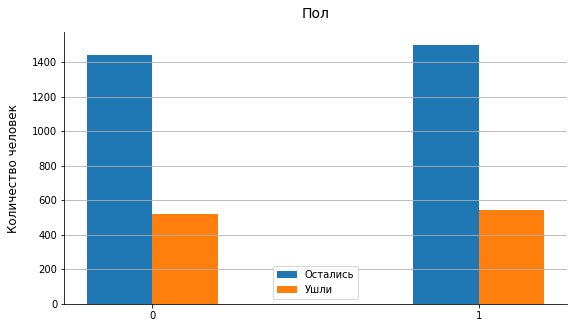

,gender,Churn,Count,%
0,0,0,1440,0.74
1,0,1,519,0.26
2,1,0,1499,0.73
3,1,1,542,0.27


In [13]:
feature_plot('gender')
feature_pivot('gender')

Распределение по полу оставшихся и ушедших пользователей не различается

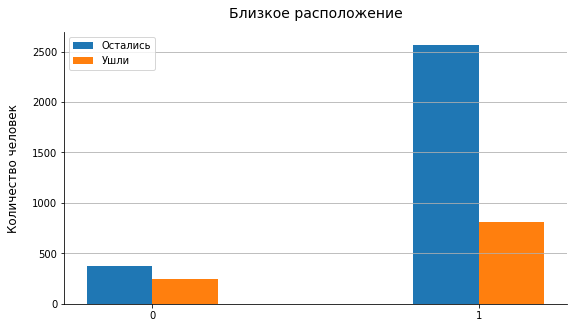

,Near_Location,Churn,Count,%
0,0,0,373,0.60
1,0,1,246,0.40
2,1,0,2566,0.76
3,1,1,815,0.24


In [14]:
feature_plot('Near_Location')
feature_pivot('Near_Location')

Во-первых, пользователей обитающих далеко от фитнес-центра гораздо меньше чем пользователей живущих недалеко, во-вторых среди пользователей, живущих далеко, доля ушедших гораздо выше, 40% против 24%, при анализе средних значений разница не выглядела такой значительной

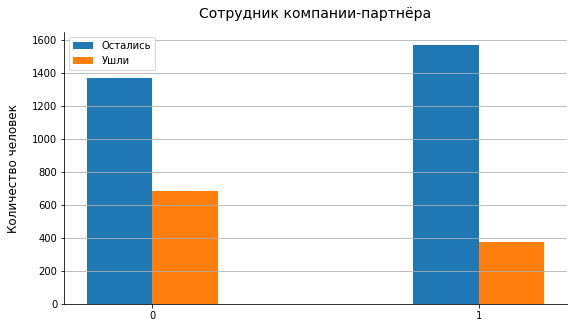

,Partner,Churn,Count,%
0,0,0,1369,0.67
1,0,1,684,0.33
2,1,0,1570,0.81
3,1,1,377,0.19


In [15]:
feature_plot('Partner')
feature_pivot('Partner')

Посетителей сотрудников компаний партнеров и прочих посетелей примерно попровну. Доля ушедших среди сотрудников меньше на 14% чем среди прочих посетителей (в абсолютном выражении 684 против 377 ушедших человек)

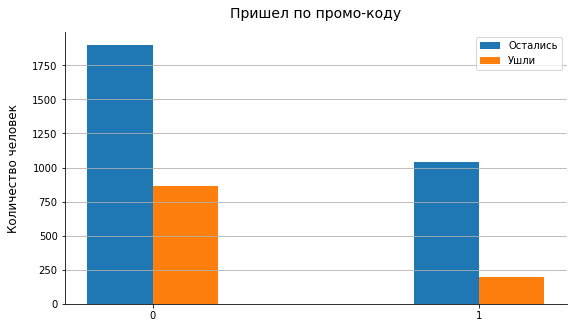

,Promo_friends,Churn,Count,%
0,0,0,1900,0.69
1,0,1,866,0.31
2,1,0,1039,0.84
3,1,1,195,0.16


In [16]:
feature_plot('Promo_friends')
feature_pivot('Promo_friends')

Пришедших по промокоду клиентов меньше но уходят они реже (отток среди воспользовавшихся промокодом 16%, среди пришедших самостоятельно 31%)

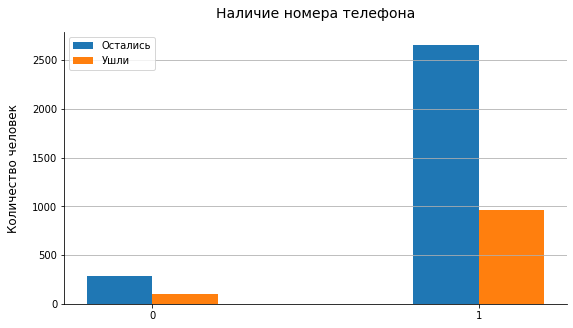

,Phone,Churn,Count,%
0,0,0,283,0.73
1,0,1,103,0.27
2,1,0,2656,0.73
3,1,1,958,0.27


In [17]:
feature_plot('Phone')
feature_pivot('Phone')

Наличие номера телефона, как и пол, на отток не влияет

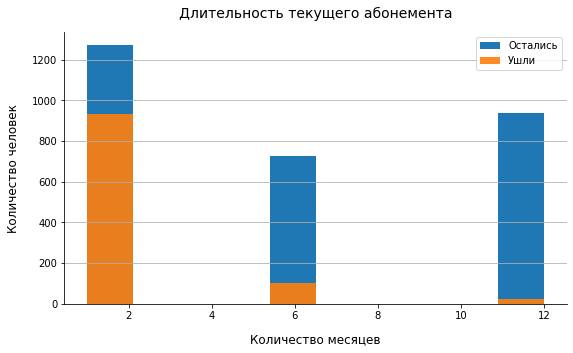

,Contract_period,Churn,Count,%
0,1,0,1273,0.58
1,1,1,934,0.42
2,6,0,729,0.88
3,6,1,104,0.12
4,12,0,937,0.98
5,12,1,23,0.02


In [18]:
feature_plot('Contract_period')
feature_pivot('Contract_period')

Посетители приобретающие абонементы на маленький срок уходят чаще: 1 месяц - отток 42%, 6 месяцев - отток 12%, 12 месяцев - отток всего 2%

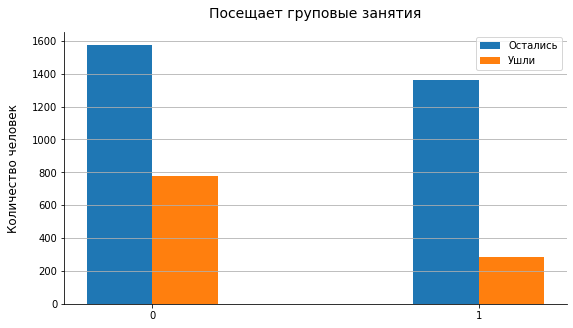

,Group_visits,Churn,Count,%
0,0,0,1575,0.67
1,0,1,776,0.33
2,1,0,1364,0.83
3,1,1,285,0.17


In [19]:
feature_plot('Group_visits')
feature_pivot('Group_visits')

Среди тех кто посещает групповые занятия отток составил 17%, а среди тех кто занимается один 33%

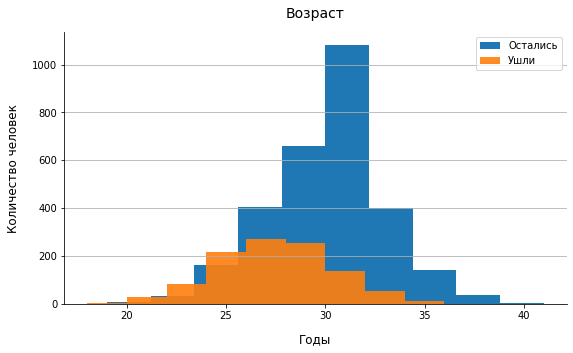

In [20]:
feature_plot('Age')

Распределения возрастов выглядят нормальными, но середина распределения возрастов ушедших клиентов смещена влево - они, в средем, моложе

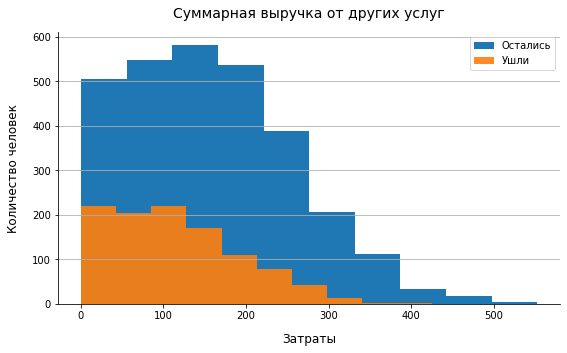

In [21]:
feature_plot('Avg_additional_charges_total')

Распределения затрат похожи на распределение Пуассона, кроме того видно что оставшиеся пользователи тратят гораздо больше чем ушедшие

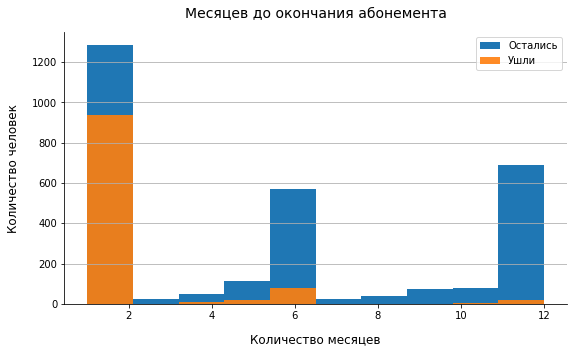

In [22]:
feature_plot('Month_to_end_contract')

Распределения месяцев оставшихся до окончания абонемента показывает что у большей части ушедших пользователей абонемент заканчивался в самое ближайшее время, точнее, так как мы смотрим на данные за предшествующий уходу месяц, абонемент, в месяц когда клиент ушел, уже закончился

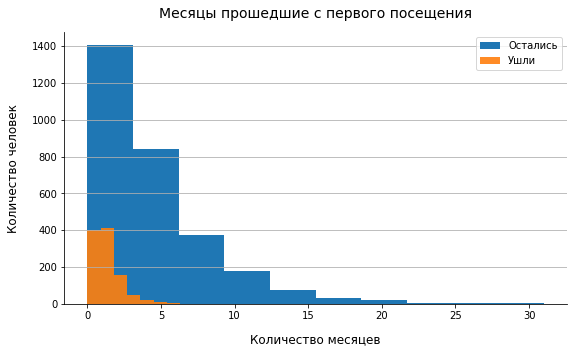

In [23]:
feature_plot('Lifetime')

Пользователи которые уходят, пользуются сервисом, в основной своей массе, меньше полугода, и, в общем, у сервиса не много клиентов старше года

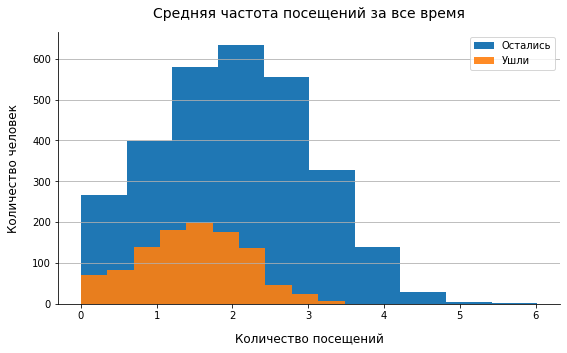

In [24]:
feature_plot('Avg_class_frequency_total')

Распределения похожи на нормальные с небольшим перекосом влево, за все время жизни ушедшие клиенты посещали фитнес-центры заметно реже чем оставшиеся

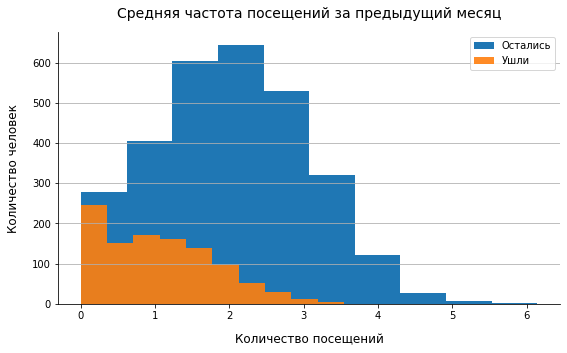

In [25]:
feature_plot('Avg_class_frequency_current_month')

Распределение посещений в месяце предшествуещему оттоку между группами заметно различается - клиенты которые не планируют уходить продолжают ходить так, как ходили все время до этого, а пользователи планирующие уйти ходят заметно реже, распределение изменяется и становится похожим на рапределение Пуассона

## Корреляция признаков<a id="stage_2_corr_matrix"></a>

Для оценки силы связи между признаками (и целевым показателем оттока) рассчитаем матрицу корреляций и отобразим ее на графике

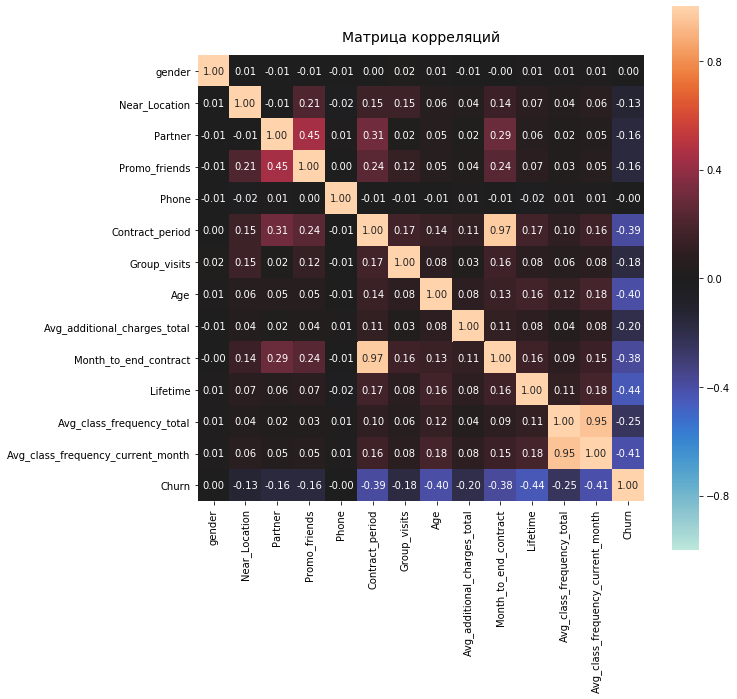

In [26]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, square=True, fmt='.2f', vmin=-1, vmax=1, cmap='icefire')
plt.title('Матрица корреляций', fontsize=14, pad=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

В соответствии со шкалой Чеддока сила связи зависит от величины коэффициента корреляции и может быть следующей:

* 0-0.3 - очень слабая
* 0.3-0.5 - слабая
* 0.5-0.7 - средняя
* 0.7-0.9 - высокая
* 0.9-1 - очень высокая

Очень высокие силы связи между признаками:

* `Avg_class_frequency_total` и `Avg_class_frequency_current_month`
* `Contract_period` и `Month_to_end_contract`

Средних и высоких сил связи нет

Слабая связь между признаками:

* `Promo_friends` и `Partner`
* `Contract_period` и `Partner`
* `Churn` и `Contract_period`
* `Churn` и `Age`
* `Churn` и `Month_to_end_contract`
* `Churn` и `Lifetime`
* `Churn` и `Avg_class_frequency_current_month`
    
Остальные связи между признаками очень слабые

## Вывод второго этапа<a id="stage_2_summary"></a>

В первую очередь стоит отметить что  **отток клиентов составил 26%** за месяц

Анализ средних значений **категориальных переменных** (которые в нашем случае обозначают 0 - явления нет, 1 - явление есть) показал, чтор распределение пола клиентов практически равномерное, 84% клиентов работают или проживают в одном районе с одним из фитнец-центров сети. Количество клиентов работающих в компаниях имеющих партнерские отношения с сетью немного (на 2%) меньше чем других постетелей, 30% клиентов пришли к нам в результате работы акции "приведи друга", контактный номер телефона заполнен у подавляющей части клиентов (90%), групповые занятия посещают 41% клиентов

**Числовые переменные** отличаются большим разнообразем, кроме двух: `Avg_class_frequency_total` (Среднее количество посещений за все время) и `Avg_class_frequency_current_month` (Среднее количество посещений за предыдущий месяц) средние, стандартные отклонения, минимумы, максимумамы и распределение по перцентилям у них оень схожи

Далее мы **разделили датафрейм на две части по признаку оттока** и сравнили средние значения признаков по этим группам:
* Возраст различается не значительно, на 3 года
* Оставшиеся клиенты тратят в среднем на 43,36 больше ушедших
* Клиенты не планирующие возвращаться в следующем месяце посещают фитнес центр в два раза реже
* Клиенты, которые посещают зал чаще и равномернее, уходят реже
* Покупка абонементов на большие сроки стимулирует клиентов продолжать пользоваться услугами фитнес-центров
* 46% оставшихся и 26% ушедших клиентов посещали групповые занятия
* Новые клиенты уходят чаще чем клиенты которые пользуются услугами продолжительно время (средняя длительность посещения среди ушедших клиентов - 1 месяц)
* В средем, среди оставшихся до момента окончания абонемента остается 5,3 месяца, в то время как для ушедших это значение составляет 1,66 месяца
* Разница между оставшимися и ушедшими клиентами в разрезе местонахождения фитнес-центра рядом с местом проживания/работы на факт ухода влияет не так значительно как подсказывает бытовая логика - всего 10%
* Среди оставшихся посетителей сотрудников компаний партнеров на 18% больше чем среди ушедших
* Среди оставшихся клиентов 35% были приглашены друзьями, среди ушедших этот показатель ниже и составляет 18%
* Признаки пола посетителя и наличия телефона среди групп не различаются

Следующим шагом было построение диаграмм распределения для каждого признака в разрезе ушедших и оставшихся клиентов и анализ каждого из них:

**Пол**<br>
Распределение по полу оставшихся и ушедших пользователей не различается

**Местонахождение**<br>
Пользователей обитающих далеко от фитнес-центра гораздо меньше чем пользователей живущих недалеко, среди пользователей, живущих далеко, доля ушедших гораздо выше, 40% против 24%, при анализе средних значений разница не выглядела такой значительной

**Сотрудник компании партнера**<br>
Посетителей сотрудников компаний партнеров и прочих посетелей примерно попровну. Доля ушедших среди сотрудников меньше на 14% чем среди прочих посетителей (в абсолютном выражении 684 против 377 ушедших человек)

**Пришли по акции**<br>
Пришедших по промокоду клиентов меньше но уходят они реже (отток среди воспользовавшихся промокодом 16%, среди пришедших самостоятельно 31%)

**Наличие номера телефона**<br>
Наличие номера телефона, как и пол, на отток не влияет

**Длительность абонемента**<br>
Посетители приобретающие абонементы на маленький срок уходят чаще: 1 месяц - отток 42%, 6 месяцев - отток 12%, 12 месяцев - отток всего 2%

**Посещение групповых занятий**<br>
Среди тех кто посещает групповые занятия отток составил 17%, а среди тех кто занимается один 33%

**Возраст**<br>
Распределения возрастов выглядят нормальными, но середина распределения возрастов ушедших клиентов смещена влево - они, в средем, моложе

**Затраты**<br>
Распределения затрат похожи на распределение Пуассона, кроме того видно что оставшиеся пользователи тратят гораздо больше чем ушедшие

**Времени до окончания абонемента**<br>
Распределения месяцев оставшихся до окончания абонемента показывает что у большей части ушедших пользователей абонемент заканчивался в самое ближайшее время, точнее, так как мы смотрим на данные за предшествующий уходу месяц, абонемент, в месяц когда клиент ушел, уже закончился

**Время прошедшее с первого посещения**<br>
Пользователи которые уходят, пользуются сервисом, в основной своей массе, меньше полугода, и, в общем, у сервиса не много клиентов старше года

**Среднее количество посещений за все время**<br>
Распределения похожи на нормальные с небольшим перекосом влево, за все время жизни ушедшие клиенты посещали фитнес-центры заметно реже чем оставшиеся

**Среднее количество посещений за прошлый месяц**<br>
Распределение посещений в месяце предшествуещему оттоку между группами заметно различается - клиенты которые не планируют уходить продолжают ходить так, как ходили все время до этого, а пользователи планирующие уйти ходят заметно реже, распределение изменяется и становится похожим на рапределение Пуассона

После анализа распределений мы построили **матрицу корреляций между признаками** и оценили силы связи по шкале Чеддока:
* Очень высокие силы связи между признаками:<br>
    `Avg_class_frequency_total` и `Avg_class_frequency_current_month`<br>
    `Contract_period` и `Month_to_end_contract`

* Средних и высоких сил связи нет

* Между остальными признаками связь либо слабая либо очень слабая

# Этап 3 - Модели прогнозирования оттока клиентов<a id="stage_3"></a>

Определим функцию для объявления, обучения и составления прогноза моделью, которая на выходе будет возвращать саму модель, массив определенных ею значений целевого признака и вероятности отнесения значений к целевому классу

In [27]:
def model_test(model, X_train, X_test, y_train, y_test):
    model = model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:,1]
    return model, predictions, probabilities

Для оценки качества модели определим функцию которая будет рассчитывать метрики по переданным ей параметрам (тестовые значения целевого показателя, предсказанные значения и вероятности), так как в исходных данных распределение целевого признака не равномерное (отток 26%) то метрика Accuracy, которая зависит от баланса классов, не может быть использована

In [28]:
def metrics(y_test, y_pred, y_pred_prob, model_name):
    metrics = pd.Series({'Precision':precision_score(y_test, y_pred),
                         'Recall':recall_score(y_test, y_pred),
                         'F1':f1_score(y_test, y_pred),
                         'ROC_AUC':roc_auc_score(y_test, y_pred_prob)},
                        name=model_name)
    return metrics

Создадим датафрейм для хранения метрик моделей

In [29]:
metrics_comp = pd.DataFrame(columns=['Precision','Recall','F1','ROC_AUC'])

## Построение моделей<a id="stage_3_mod"></a> 

Объявим следующие наборы данных
X - значения признаков
y - значения целевой переменной

Разделим данные на обучающие и валидационные наборы в соотношении 80 на 20

In [30]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Логистическая регрессия

Воспользуемся первым алгоритмом для бинарной классификации - логистической регрессией

In [31]:
model_lr, predictions, probabilities = model_test(LogisticRegression(solver='liblinear', random_state=0),
                                                  X_train, X_test, y_train, y_test)

Рассчитаем метрики

In [32]:
metrics_lr = metrics(y_test, predictions, probabilities, 'Логистическая регрессия')

Добавим метрики в датафрейм для последующего сравнения

In [33]:
metrics_comp = metrics_comp.append(metrics_lr)

### Случайный лес

Проведем бинарную классификацию другим алгоритмом - случайным лесом

In [34]:
model_rf, predictions, probabilities = model_test(RandomForestClassifier(n_estimators=100, random_state=0),
                                                  X_train, X_test, y_train, y_test)

Рассчитаем метрики

In [35]:
metrics_rf = metrics(y_test, predictions, probabilities, 'Случайный лес')

Добавим метрики в таблицу, для сравнения

In [36]:
metrics_comp = metrics_comp.append(metrics_rf)

Сравним метрики моделей

In [37]:
metrics_comp.round(2).style.background_gradient(cmap='Blues')

,Precision,Recall,F1,ROC_AUC
Логистическая регрессия,0.86,0.83,0.85,0.97
Случайный лес,0.84,0.82,0.83,0.97


Метрики показывают что модель полученная алгоритмом **логистической регресии лучше**

## Построение по масштрабированным признакам<a id="stage_3_st_norm"></a> 

### Стандартизация

Проведем стандартизацию тренировочных и валидационных наборов признаков и построим теже самые модели, метрики запишем в массив с метриками

In [38]:
scaler = StandardScaler()

X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [39]:
model_lr_st, predictions, probabilities = model_test(LogisticRegression(solver='liblinear', random_state=0),
                                                  X_train_st, X_test_st, y_train, y_test)
metrics_lr_st = metrics(y_test, predictions, probabilities, 'Логистическая регрессия (станд)')
metrics_comp = metrics_comp.append(metrics_lr_st)

In [40]:
model_rf_st, predictions, probabilities = model_test(RandomForestClassifier(n_estimators=100, random_state=0),
                                                  X_train_st, X_test_st, y_train, y_test)
metrics_rf_st = metrics(y_test, predictions, probabilities, 'Случайный лес (станд)')
metrics_comp = metrics_comp.append(metrics_rf_st)

In [41]:
metrics_comp.round(2).style.background_gradient(cmap='Blues')

,Precision,Recall,F1,ROC_AUC
Логистическая регрессия,0.86,0.83,0.85,0.97
Случайный лес,0.84,0.82,0.83,0.97
Логистическая регрессия (станд),0.85,0.83,0.84,0.97
Случайный лес (станд),0.84,0.81,0.83,0.97


Судя по метрикам, **после стандартизации модели стали немного хуже**

### Нормализация

Попробуем привести нормализацию признаков другим скейлером, по аналогии с предыдщим методом обучим модели и запишем метрики в датафрейм

In [42]:
scaler = MinMaxScaler()

X_train_nm = scaler.fit_transform(X_train)
X_test_nm = scaler.transform(X_test)

In [43]:
model_lr_nm, predictions, probabilities = model_test(LogisticRegression(solver='liblinear', random_state=0),
                                                  X_train_nm, X_test_nm, y_train, y_test)
metrics_lr_nm = metrics(y_test, predictions, probabilities, 'Логистическая регрессия (норм)')
metrics_comp = metrics_comp.append(metrics_lr_nm)

In [44]:
model_rf_nm, predictions, probabilities = model_test(RandomForestClassifier(n_estimators=100, random_state=0),
                                                  X_train_nm, X_test_nm, y_train, y_test)
metrics_rf_nm = metrics(y_test, predictions, probabilities, 'Случайный лес (норм)')
metrics_comp = metrics_comp.append(metrics_rf_nm)

In [45]:
metrics_comp.round(2).style.background_gradient(cmap='Blues')

,Precision,Recall,F1,ROC_AUC
Логистическая регрессия,0.86,0.83,0.85,0.97
Случайный лес,0.84,0.82,0.83,0.97
Логистическая регрессия (станд),0.85,0.83,0.84,0.97
Случайный лес (станд),0.84,0.81,0.83,0.97
Логистическая регрессия (норм),0.88,0.85,0.86,0.97
Случайный лес (норм),0.84,0.81,0.83,0.97


**Нормализация признаков улучшила метрики модели логистической регрессии** и ухудшила метрики случайного леса

## Исключение связанных признаков<a id="stage_3_corr"></a> 

В обе модели разработчиками библиотек уже встроены алгоритмы регуляризации сильно коррелирующих признаков, но, для чистоты эксперимента, удалим по одному признаку и рассчитаем метрики для каждой модели по обновленным наборам нормализованных данных

In [46]:
metrics_corr_test = metrics_comp

for feature in ['Avg_class_frequency_total', 'Avg_class_frequency_current_month', 
                'Contract_period', 'Month_to_end_contract']:
    X = df.drop(['Churn', feature], axis=1)
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=0)
    
    scaler = MinMaxScaler()
    X_train_nm = scaler.fit_transform(X_train)
    X_test_nm = scaler.transform(X_test)
    
    for mod, name in [[LogisticRegression(solver='liblinear', random_state=0), 'Логистическая регрессия'],
                      [RandomForestClassifier(n_estimators=100, random_state=0), 'Случайный лес']]:
        model, predictions, probabilities = model_test(mod, X_train_nm, X_test_nm, y_train, y_test)
        series_name = name + ' удален ' + feature
        metrics_corr_test = metrics_corr_test.append(metrics(y_test, predictions, probabilities, series_name))

In [47]:
metrics_corr_test.round(2).style.background_gradient(cmap='Blues')

,Precision,Recall,F1,ROC_AUC
Логистическая регрессия,0.86,0.83,0.85,0.97
Случайный лес,0.84,0.82,0.83,0.97
Логистическая регрессия (станд),0.85,0.83,0.84,0.97
Случайный лес (станд),0.84,0.81,0.83,0.97
Логистическая регрессия (норм),0.88,0.85,0.86,0.97
Случайный лес (норм),0.84,0.81,0.83,0.97
Логистическая регрессия удален Avg_class_frequency_total,0.81,0.79,0.8,0.96
Случайный лес удален Avg_class_frequency_total,0.81,0.75,0.78,0.95
Логистическая регрессия удален Avg_class_frequency_current_month,0.8,0.78,0.79,0.95
Случайный лес удален Avg_class_frequency_current_month,0.8,0.76,0.78,0.94


Удаление сильно коррелирующих признаков ухудшает метрики это значит, что встроенная в алгоритмы регуляризация работает корректно, поэтому попарное удаление коррелирующих признаков мы проводить не будем

Проведем итоговое сравнение метрик построенных моделей

In [48]:
metrics_comp.round(2).style.background_gradient(cmap='Blues')

,Precision,Recall,F1,ROC_AUC
Логистическая регрессия,0.86,0.83,0.85,0.97
Случайный лес,0.84,0.82,0.83,0.97
Логистическая регрессия (станд),0.85,0.83,0.84,0.97
Случайный лес (станд),0.84,0.81,0.83,0.97
Логистическая регрессия (норм),0.88,0.85,0.86,0.97
Случайный лес (норм),0.84,0.81,0.83,0.97


Лучше всего, по метрикам, выглядит модель построенная по нормализованным данным алгоритмом Логистической регресии

**Precision - 0,88** показывает долю правильно отнесенных к классу 1 объектов действительно находящихся в этом классе

**Recall - 0,85** показывает долю отнесенных к классу 1 объектов среди всех попыток

**F1 - 0.86** баланс между метриками **Precision** и **Recall**

**ROC_AUC - 0.97** одинакова для всех моделей и показывает как хорошо наша модель сортирует классы

Построим итоговую модель для прогнозирования оттока

In [49]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
X_train_nm = scaler.fit_transform(X_train)
X_test_nm = scaler.transform(X_test)

model_lr, predictions_lr, probabilities_lr = model_test(LogisticRegression(solver='liblinear', random_state=0), 
                                                        X_train_nm, X_test_nm, y_train, y_test)

Отобразим веса для признаков на которые ориентируется построенная модель

In [50]:
coef_weight = pd.DataFrame({'feature':X.columns, 'coef_lr':model_lr.coef_[0]})
coef_weight['abs_coef'] = abs(coef_weight['coef_lr'])
coef_weight.sort_values('abs_coef', ascending=False)

,feature,coef_lr,abs_coef
10,Lifetime,-11.441143,11.441143
12,Avg_class_frequency_current_month,-8.562086,8.562086
7,Age,-5.205861,5.205861
11,Avg_class_frequency_total,4.667330,4.667330
8,Avg_additional_charges_total,-2.200801,2.200801
5,Contract_period,-1.659673,1.659673
9,Month_to_end_contract,-1.092967,1.092967
6,Group_visits,-0.578000,0.578000
3,Promo_friends,-0.390843,0.390843
2,Partner,-0.116116,0.116116


Наибольший вес (по модулю) у следующих признаков:
* Месяцы прощедшие с первого посещения
* Средняя частота посещений за предыдущий месяц
* Возраст
* Средняя частота посещений за все время

Наименьший вес:
* Наличие номера телефона
* Пол
* Близкое расположение
* Сотрудник компании-партнёра

Так как мы определяем вероятность оттока клиента, и с клиентами, которых модель определит как уходящих в следующем месяце, планируем проводить работу по их удержанию то метрика **Recall важнее чем Precision**, попробуем изменить порог вероятности отнесения объекта к классу 1

In [51]:
treshhold_test = pd.DataFrame(columns=['Precision','Recall','F1','ROC_AUC'])
treshhold_change = []
for treshhold in np.arange(0.05, 0.55, 0.05):
    custom_predictions = [0 if i < treshhold else 1 for i in probabilities_lr]
    metrics_trh_ch = metrics(y_test, custom_predictions, probabilities_lr,'Логистическая регрессия')
    treshhold_test = treshhold_test.append(metrics_trh_ch)
    treshhold_change.append(round(treshhold, 2))
treshhold_test.index = treshhold_change
treshhold_test.index.name = 'treshhold'
treshhold_test.round(2).style.background_gradient(cmap='Blues')

,Precision,Recall,F1,ROC_AUC
treshhold,,,,
0.05,0.42,0.99,0.6,0.97
0.1,0.49,0.98,0.66,0.97
0.15,0.56,0.98,0.71,0.97
0.2,0.61,0.96,0.75,0.97
0.25,0.65,0.95,0.78,0.97
0.3,0.69,0.92,0.79,0.97
0.35,0.73,0.91,0.81,0.97
0.4,0.79,0.89,0.84,0.97
0.45,0.82,0.86,0.84,0.97


Снижение порога даже до 0,4 совсем немного улучшает метрику **Recall** но при этом значительно ухудшает метрики **Precision** и **F1**, от идеи применения порога отличного от 0,5 придется отказаться

## Вывод третьего этапа<a id="stage_3_summary"></a>

Нами было построено две модели для бинарной классификации:
* Логистическая регрессия
* Случайный лес

После обучения моделей мы провели тесты на валидационных выборках и рассчитали метрики классификации (Precision, Recall, F1, ROC-AUC), мы не смогли использовать метрику **Accuracy** так как распределние целевого признака (оттока клиентов) в нашем случае не равномерное

Модель построенная алгоритмом логистической регрессии оказалась лучше и точнее

Далее мы решили проверить результаты обучения моделей по стандартизированным и нормализированным данным, сравнение метрик показало что стандартизация данных немного ухудшила обе модели, а нормализация данных улучшила модель по алгоритму логистической регрессии но ухудшила модель случайного леса

В обе модели разработчиками библиотек уже встроены алгоритмы регуляризации сильно коррелирующих признаков, но, для чистоты эксперимента, мы решили удалить каждый из четырех сильно коллерирующих признаков по одному и сравнить метрики для каждой модели по обновленным наборам нормализованных данных: удаление сильно коррелирующих признаков ухудшило метрики обеих моделей это значит, что встроенная в алгоритмы регуляризация работает корректно

В итоге, для дальнейшей работы нами была выбрана модель построенная алгоритмом логистической регрессии по нормализованным данным, ее метрики классификации получились следующими:

* **Precision - 0,88** показывает долю правильно отнесенных к классу 1 объектов действительно находящихся в этом классе

* **Recall - 0,85** показывает долю отнесенных к классу 1 объектов среди всех попыток

* **F1 - 0.86** баланс между метриками **Precision** и **Recall**

* **ROC_AUC - 0.97** одинакова для всех моделей и показывает как хорошо наша модель сортирует классы

При отнесении наблюдения к тому или иному классу модель по большей части ориентируется на следующие признаки:
* Месяцы прощедшие с первого посещения
* Средняя частота посещений за предыдущий месяц
* Возраст
* Средняя частота посещений за все время

Так как мы определяем вероятность оттока клиента, и с клиентами, которых модель определит как уходящих в следующем месяце, планируем проводить работу по их удержанию, то метрика **Recall важнее чем Precision**. Мы решили изменить порог вероятности отнесения объекта к классу 1 для того чтобы повысить ее, но расчет метрик по новому порогу показал, что снижение порога отнесения даже до 0,4 совсем немного улучшает метрику **Recall** и при этом значительно ухудшает метрики **Precision** и **F1**, от идеи применения порога отличного от 0,5 придется отказаться

# Этап 4 - Классификация клиентов<a id="stage_4"></a>

## Построение дендрограммы<a id="stage_4_dend"></a>

Прежде чем разделять клиентов на кластеры нам необходимо узнать количество этих кластеров, для этого построим матрицу расстояний и дендрограмму на ее основе

Подготовим массив признаков

In [52]:
X = df.drop('Churn', axis=1)

Стандартизируем его

In [53]:
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

Рассчитаем матрицу расстояний

In [54]:
linked = linkage(X_st, method = 'ward')

На основании матрицы расстояний построим диаграмму распределения признаков по классам

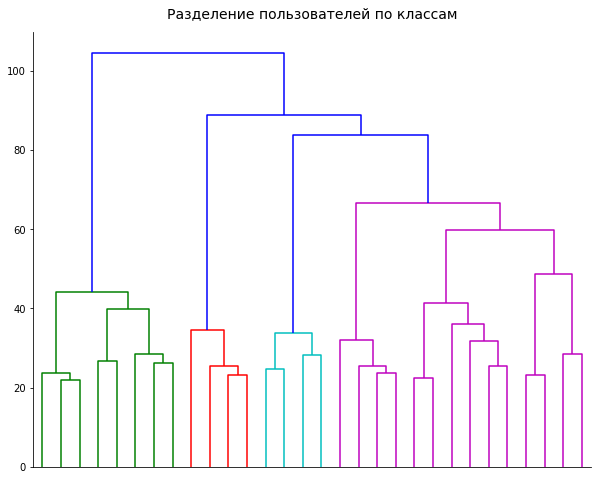

In [55]:
plt.figure(figsize=(10, 8))  
dendrogram(linked, orientation='top', truncate_mode='lastp')
plt.title('Разделение пользователей по классам', fontsize=14, pad=14)
plt.xticks([])
sns.despine()
plt.show()

Предложенное оптимальное число кластеров - 5 (по количеству цветов на графике)

## Разделение пользователей на классы<a id="stage_4_clusters"></a>

Разделим всех пользователей на кластеры алгоритмом K-Means, для этого укажем количество кластеров - 5 (на основании разделения дендрограммы по цветам)

In [56]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_st)

Добавим столбец с обозначение класса куда относится пользователь в таблицу оцифрованных анкет

In [57]:
df['cluster'] = labels

Сгруппироуем таблицу по классам пользователей и найдем средние значения признаков

In [58]:
df.pivot_table(index='cluster', aggfunc='mean').sort_values('Churn')

,Age,Avg_additional_charges_total,Avg_class_frequency_current_month,Avg_class_frequency_total,Churn,Contract_period,Group_visits,Lifetime,Month_to_end_contract,Near_Location,Partner,Phone,Promo_friends,gender
cluster,,,,,,,,,,,,,,
0,29.980218,160.706969,1.976225,1.983305,0.027695,10.884273,0.543027,4.738872,9.950544,0.959446,0.783383,1.000000,0.574679,0.502473
4,30.127838,161.724258,2.849473,2.851531,0.068100,2.665472,0.473118,4.896057,2.455197,0.976105,0.356033,0.998805,0.229391,0.560335
1,29.301299,143.957664,1.716369,1.847220,0.267532,4.787013,0.425974,3.924675,4.475325,0.862338,0.470130,0.000000,0.306494,0.522078
2,28.477228,135.457501,1.477324,1.660461,0.443564,2.352475,0.215842,2.809901,2.198020,0.000000,0.463366,1.000000,0.079208,0.495050
3,28.167987,131.622204,1.012983,1.247634,0.514263,1.948494,0.341521,2.440571,1.856577,1.000000,0.350238,1.000000,0.240095,0.485737


Алгоритм K-Means разделил пользователей на 5 классов, среди которых 2 класса с очень низкой долей оттока (2% и 6%) один с вероятностью оттока 27% и два кластера с вероятностью оттока 44% и 51%.

Средние значения признаков получились следующие:

* Возраст - средний возраст пользователя в группах с низким оттоком выше
* Затраты на другие услуги - в кластерах с высоким оттоком пользователи тратят меньше денег
* Частота посещений за предшествующий уходу месяц - чем ниже уровень оттока в группе тем чаще клиенты посещают фитнес-центры
* Частота посещений за все время - аналогично частоте за предыдущий месяц - в группах с низким уровнем оттока пользователи ходят на занятия чаще
* Длительность абонемента - клиентов с годовым абонементом больше всего в группе с самым низким оттоком
* Количество пользователей посещающих групповые занятия сильно не фрагментировано среди классов, разница присутствует, но не коллосальная
* Время с момента первого обращения - чем выше доля оттока в группе тем меньше "возраст" клиента
* Количество месяцев до конца абонемента - чем меньше времени оплаченного абонемента тем более "худший" кластер попадает пользователь
* Расстояние до фитнес-центра - разделение по кластерам получилось очень странным, в четырех кластерах (2 очень хороших и средний и самый плохо) практически все клиенты обитают недалеко от фитнес-центров, в четвертом кластере таких нет вообще
* Сотрудник компании партнера - в лучшем кластере таких большинство, в остальных кластерах распределение равномерное
* Пользователи пришедшие по акции "пригласи друга" распреелены не равномерно, но в лучшем кластере таких больше половины, в одном из наихудших - всего 8%
* Пол клиента и наличие телефона на распределение по кластерам практически не влияют

Теперь для каждого кластера построим диаграммы распределения признаков, для этого определим две функции

1) функция для построения диаграмм категориальных признаков

2) функция для построения диаграмм числовых признаков

In [59]:
def categorical_feature_subplots(cluster):
    data = df[df['cluster'] == cluster]
    feat_num = 0
    fig, axes = plt.subplots(3, 2, figsize=(10,12))
    for i in range(0,3):
        for j in range(0,2):
            axes[i, j].bar(height=data[categorical_feature[feat_num]].value_counts().sort_index(), x=[0,1], width=0.4)
            axes[i, j].set_title(feature_translate[categorical_feature[feat_num]])
            axes[i, j].set_ylabel('Количество человек')
            axes[i, j].set_xticks([0,1])
            plt.suptitle('Группа: {}, Доля оттока: {}'.format(cluster, round(data['Churn'].mean(), 2)), 
                         y=1.02, fontsize=14)
            feat_num += 1
            plt.tight_layout()

In [60]:
def numerical_feature_subplots(cluster):
    data = df[df['cluster'] == cluster]
    feat_num = 0
    fig, axes = plt.subplots(4, 2, figsize=(10,20))
    for i in range(0,4):
        for j in range(0,2):
            try:
                axes[i, j].hist(data[numeric_feature[feat_num]])
                axes[i, j].set_title(feature_translate[numeric_feature[feat_num]])
                axes[i, j].set_xlabel(feature_unit[numeric_feature[feat_num]])
                axes[i, j].set_ylabel('Количество человек')
                plt.suptitle('Группа: {}, Доля оттока: {}'.format(cluster, round(data['Churn'].mean(), 2)), 
                             y=1.02, fontsize=14)
                feat_num += 1  
            except:
                axes[i, j].axis('off')
            plt.tight_layout()

Теперь применим написанные функции для построения диаграмм для каждого кластера

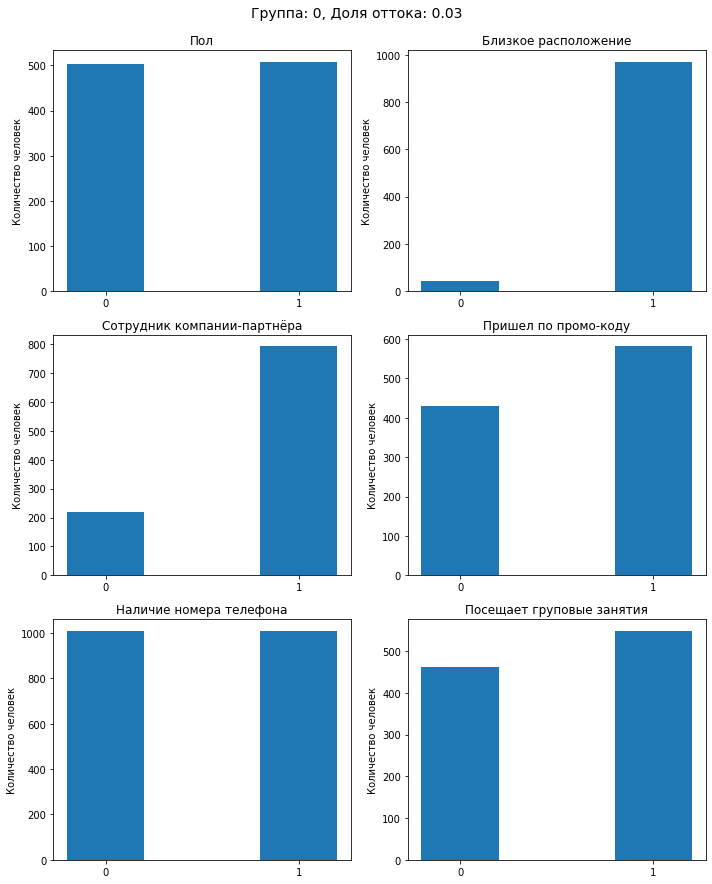

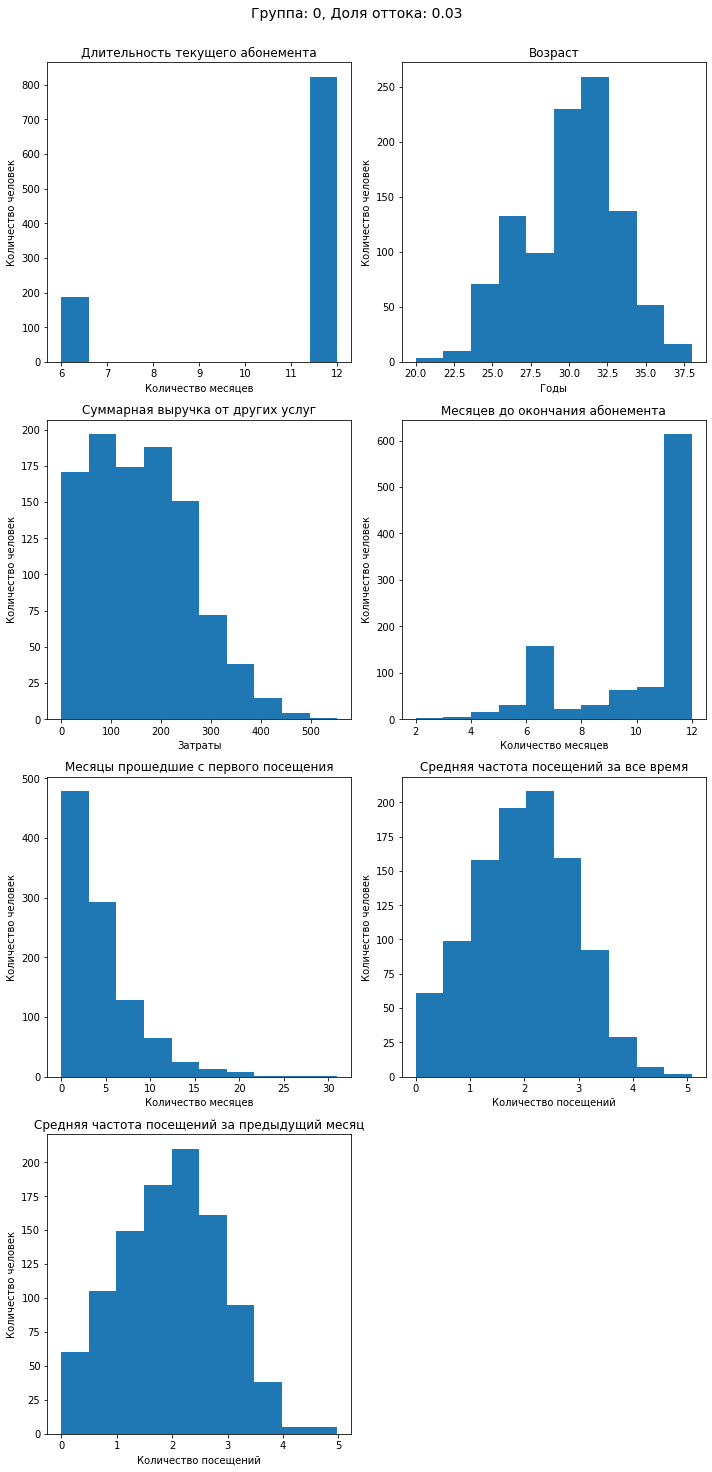

In [61]:
categorical_feature_subplots(0)
numerical_feature_subplots(0)

Это группа с наименьшей долей оттока, мы можем считать что клиенты попавшие в эту группу точно не уйдут в следующем месяце

Сюда отнесены более возрастные клиенты которые часто ходят в зал и имеют годовые абонементы которые не скоро закончатся, живут или работают они не далеко от зала, большая часть из них является сотрудниками компаний партнеров, большая часть из этих клиентов посещает групповые занятия

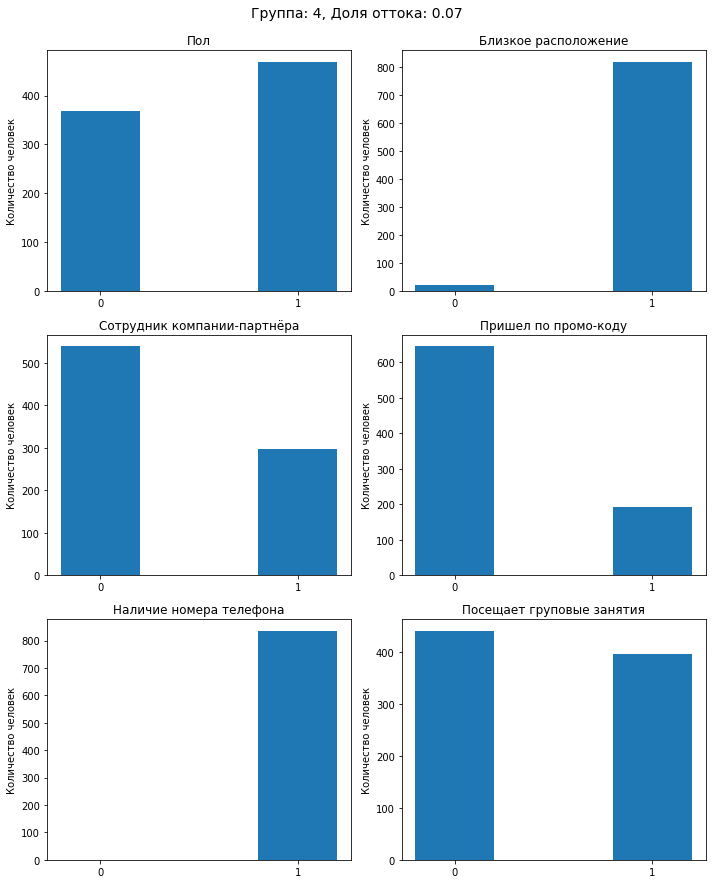

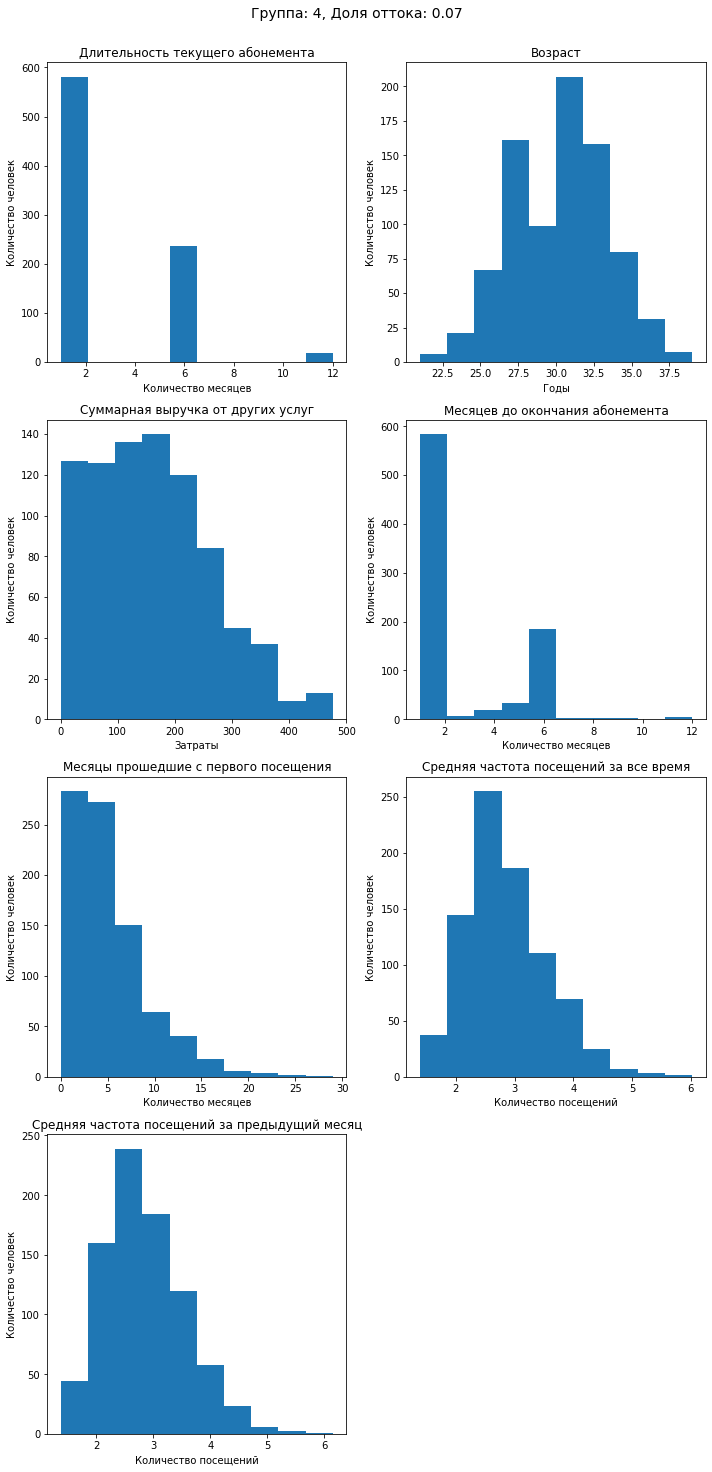

In [62]:
categorical_feature_subplots(4)
numerical_feature_subplots(4)

Вторая группа, доля оттока лишь немного выше чем в предыдущей но, что примечательно, в нее попало большое количество клиентов у которых заканчивается абонемент, то есть это лояльные клиенты которые скорее всего продлят абонемент после завершения, они тратят больше денег на дополнительные услуги, практически все живут недалеко, ходят стабильно и уже длительное время, многие являются сотрудниками компаний партнеров, около половины из них ходит на групповые занятия

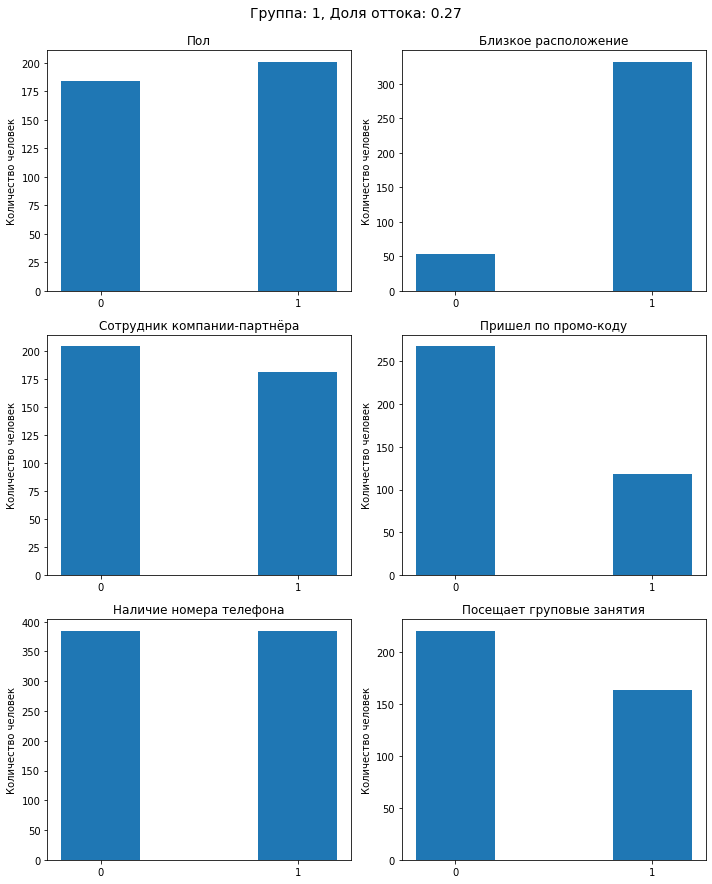

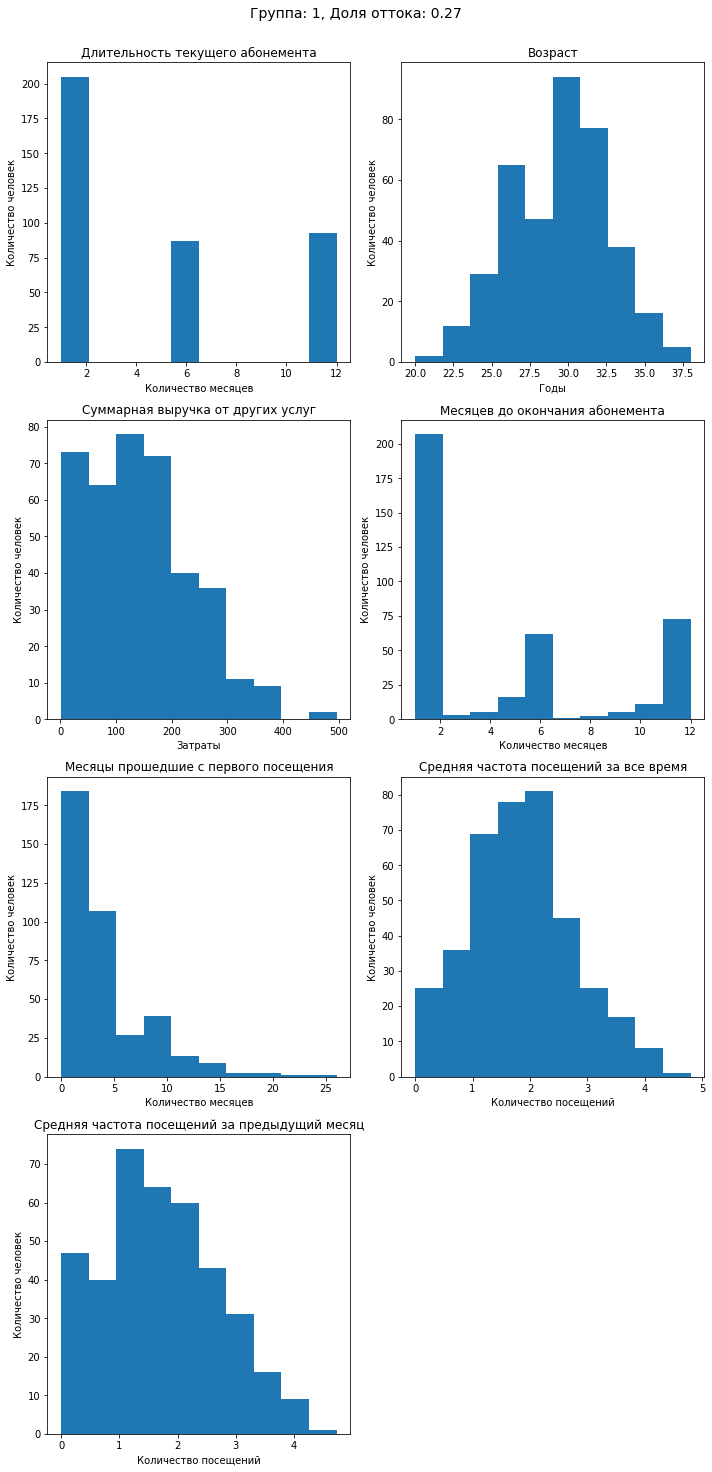

In [63]:
categorical_feature_subplots(1)
numerical_feature_subplots(1)

Третья группа, доля оттока (27%) совпадает со средней долей оттока среди всех клиентов (26%), клиенты которые попали в нее "средние" ничем особо не выделяющиеся, их поведение тяжело предсказать

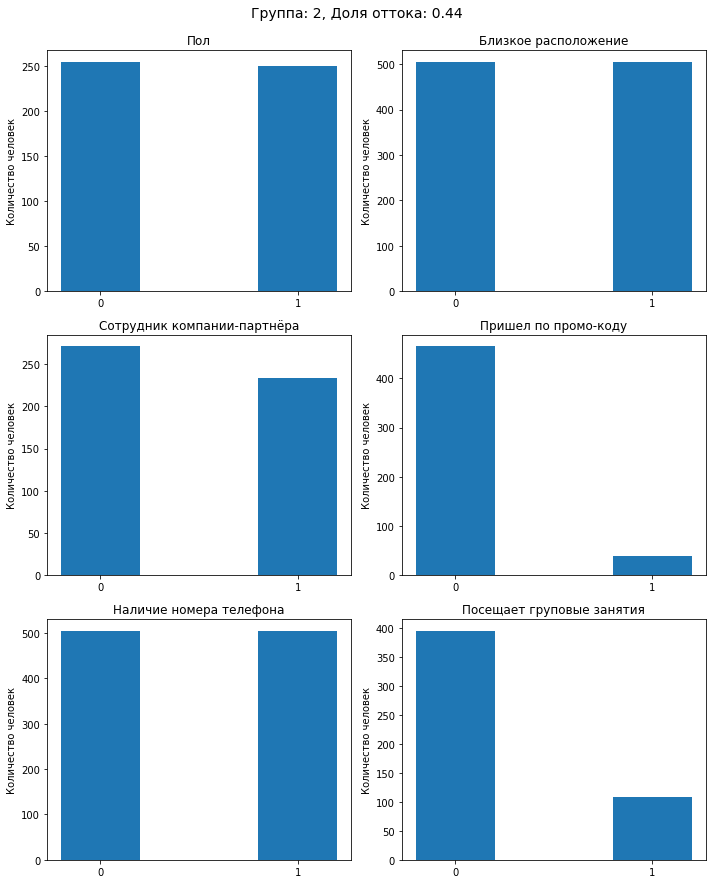

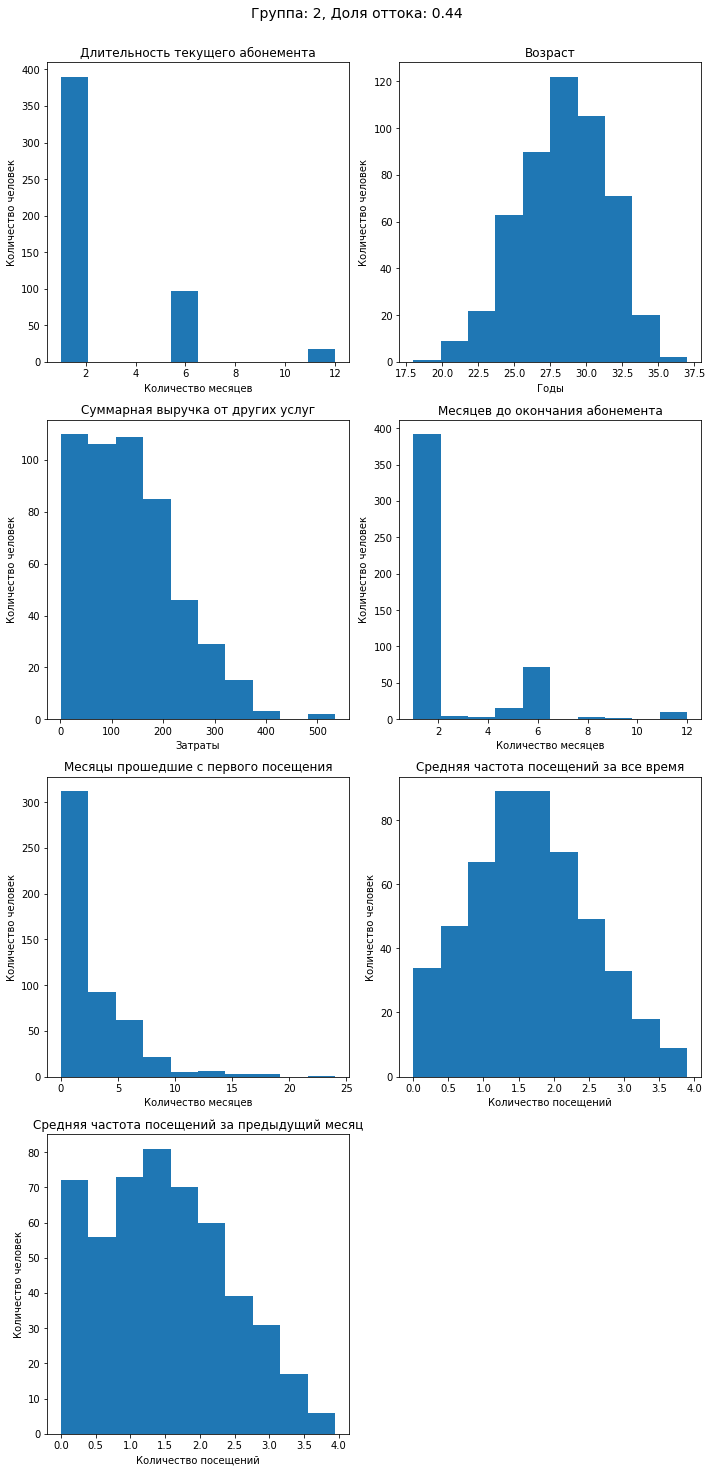

In [64]:
categorical_feature_subplots(2)
numerical_feature_subplots(2)

Первая из "плохих групп" доля оттока среди клиентов попавших в нее 44%, половина из них живет далеко от фитнес-центра, абонементы у этих клиентов заканчиваются, однако половина из этих клиентов является сотруднкиами компаний партнеров. Большая часть из них не посещают групповые занятия, в среднем клиенты из этой группы пользуются услугами сети пока небольшое время, меньше полугода

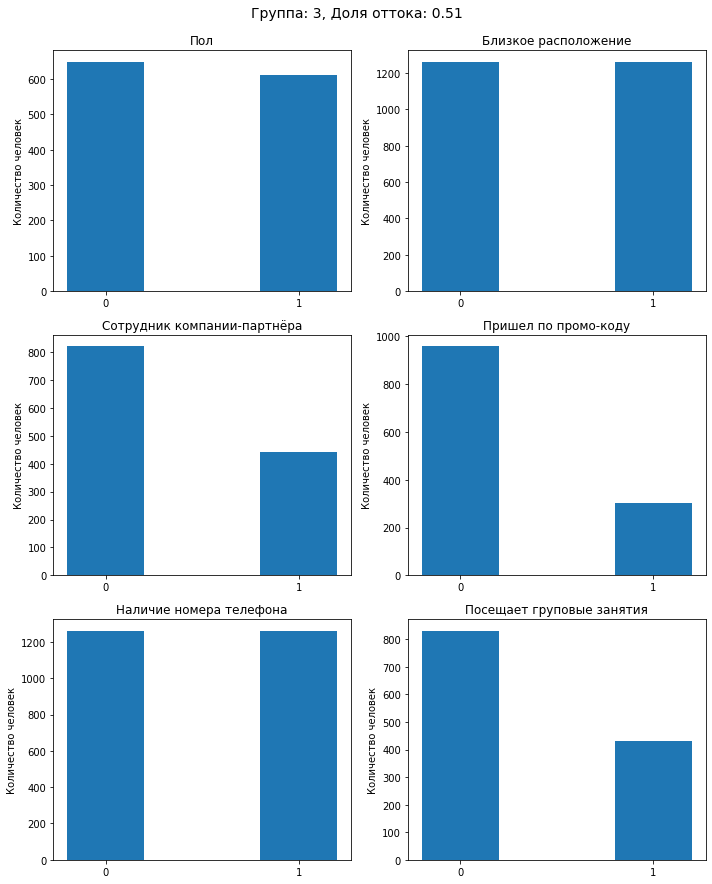

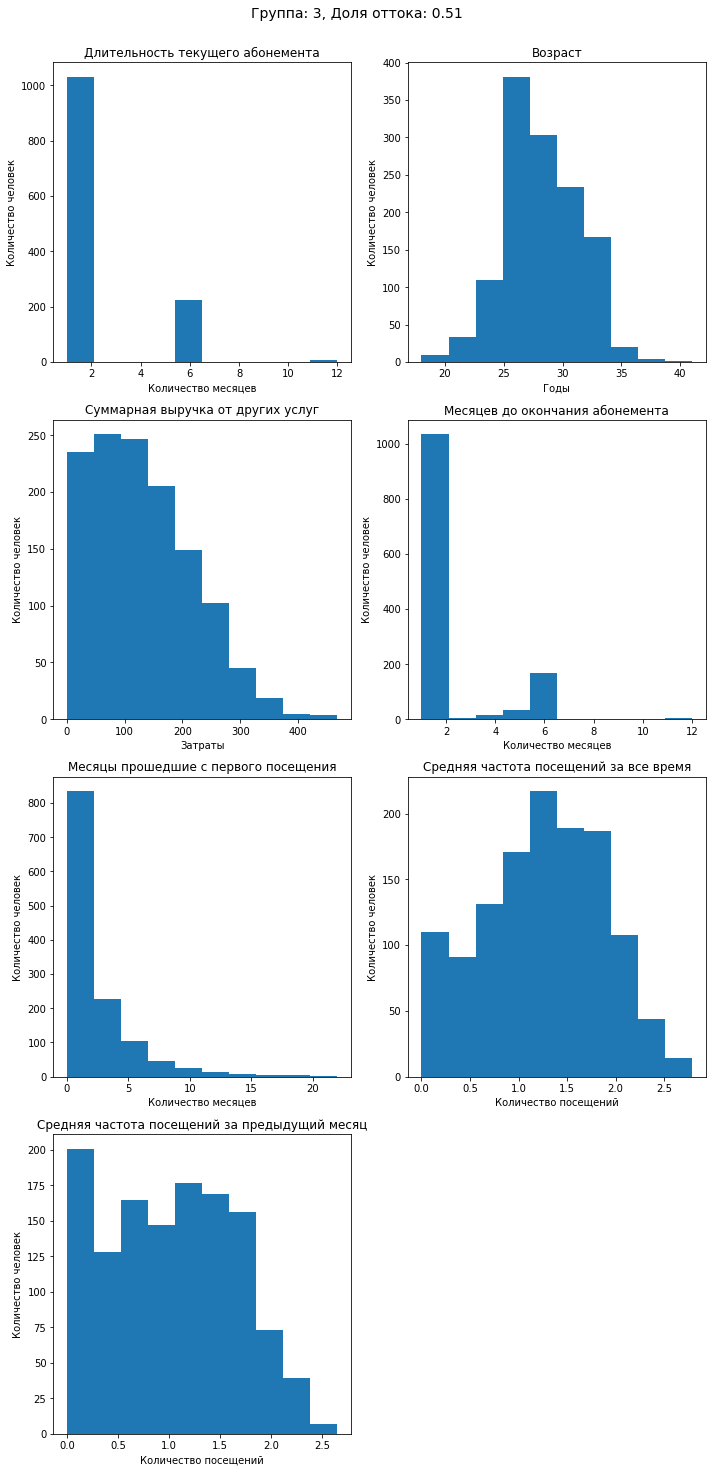

In [65]:
categorical_feature_subplots(3)
numerical_feature_subplots(3)

Самая плохая группа, доля оттока 51%, годовых абонементов крайне мало, большая часть абонементов закончится уже в следующем месяце, клиенты редко посещают зал и далеко живут, большая часть не воспользовалось акцией приведи друга и не ходит на групповые занятия, что примечательно кроме совсем новых клиентов в эту группу также попало некоторое количество клиентов которые ходят уже довольно длительное время, но нерегулярно

## Вывод четвертого этапа<a id="stage_4_summary"></a>

Для того чтобы разделить клиентво на кластеры мы построили дендрограмму и на ее основе определили количество кластеров **(5 цветов - 5 кластеров)**

Далее мы использовали алгоритм **K-Means** и разделили все анкеты на 5 классов: среди которых 2 класса с очень низкой долей оттока (2% и 6%) один с вероятностью оттока 27% и два кластера с вероятностью оттока 44% и 51%.

Средние значения признаков в кластерах получились следующие:

* Возраст - средний возраст пользователя в группах с низким оттоком выше
* Затраты на другие услуги - в кластерах с высоким оттоком пользователи тратят меньше денег
* Частота посещений за предшествующий уходу месяц - чем ниже уровень оттока в группе тем чаще клиенты посещают фитнес-центры
* Частота посещений за все время - аналогично частоте за предыдущий месяц - в группах с низким уровнем оттока пользователи ходят на занятия чаще
* Длительность абонемента - клиентов с годовым абонементом больше всего в группе с самым низким оттоком
* Количество пользователей посещающих групповые занятия сильно не фрагментировано среди классов, разница присутствует, но не коллосальная
* Время с момента первого обращения - чем выше доля оттока в группе тем меньше "возраст" клиента
* Количество месяцев до конца абонемента - чем меньше времени оплаченного абонемента тем более "худший" кластер попадает пользователь
* Расстояние до фитнес-центра - разделение по кластерам получилось очень странным, в четырех кластерах (2 очень хороших и средний и самый плохо) практически все клиенты обитают недалеко от фитнес-центров, в четвертом кластере таких нет вообще
* Сотрудник компании партнера - в лучшем кластере таких большинство, в остальных кластерах распределение равномерное
* Пользователи пришедшие по акции "пригласи друга" распреелены не равномерно, но в лучшем кластере таких больше половины, в одном из наихудших - всего 8%
* Пол клиента и наличие телефона на распределение по кластерам практически не влияют

Мы построили диаграммы распределения признаков для каждого класса и у нас сложились следующие впечатления о клиентах попавших в эти группы:

**"Первая"** группа: Это группа с наименьшей долей оттока, мы можем считать что клиенты попавшие в эту эгруппу точно не уйдут в следующем месяце

Сюда отнесены более возрастные клиенты которые часто ходят в зал и имеют годовые абонементы которые не скоро закончатся, живут или работают они не далеко от зала, большая часть из них является сотрудниками компаний партнеров, большая часть из этих клиентов посещает групповые занятия

**"Вторая"** группа, доля оттока лишь немного выше чем в предыдущей но, что примечательно, в нее попало большое количество клиентов у которых заканчивается абонемент, то есть это лояльные клиенты которые скорее всего продлят абонемент после завершения, они тратят больше денег на дополнительные услуги, практически все живут недалеко, ходят стабильно и уже длительное время, многие являются сотрудниками компаний партнеров, около половины из них ходит на групповые занятия

**"Третья"** группа, доля оттока (27%) совпадает со средней долей оттока среди всех клиентов (26%), клиенты которые попали в нее "средние" ничем особо не выделяющиеся, их поведение тяжело предсказать

**"Четвертая"** группа - первая из "плохих групп" доля оттока среди клиентов попавших в нее 44%, половина из них живет далеко от фитнес-центра, абонементы у этих клиентов заканчиваются, однако половина из этих клиентов является сотруднкиами компаний партнеров. Большая часть из них не посещают групповые занятия, в среднем клиенты из этой группы пользуются услугами сети пока небольшое время, меньше полугода

**"Пятая"** группа - самая плохая, доля оттока 51%, годовых абонементов крайне мало, большая часть абонементов закончится уже в следующем месяце, клиенты редко посещают зал и далеко живут, большая часть не воспользовалось акцией приведи друга и не ходит на групповые занятия, что примечательно кроме совсем новых клиентов в эту группу также попало некоторое количество клиентов которые ходят уже довольно длительное время, но нерегулярно

# Общий вывод и рекомендации<a id="conclusion"></a>

# Общий вывод<a id="conclusion_1"></a>

После того как мы загрузили данные в датафрейм мы не обнаружили в нем пропущенных данных, типы данных в столбцах соответствовали их содержимому

Далее мы приступили к **исследовательскому анализу данных**

В первую очередь мы отметили что **отток клиентов составил 26% за месяц**

Анализ средних значений категориальных переменных показал, что распределение пола клиентов практически равномерное, 84% клиентов работают или проживают в одном районе с одним из фитнес-центров сети. Количество клиентов работающих в компаниях имеющих партнерские отношения с сетью немного (на 2%) меньше чем других постетелей, 30% клиентов пришли к нам в результате работы акции "приведи друга", контактный номер телефона заполнен у подавляющей части клиентов (90%), групповые занятия посещают 41% клиентов

Различия в средних показателях между ушедшими и оставшимися клиентами:
* Возраст различается не значительно, на 3 года
* Оставшиеся клиенты тратят на дополнительные услуги в среднем на 43,36 больше ушедших
* Клиенты не планирующие возвращаться в следующем месяце посещают фитнес центр в два раза реже
* Покупка абонементов на большие сроки стимулирует клиентов продолжать пользоваться услугами фитнес-центров
* 46% оставшихся и 26% ушедших клиентов посещали групповые занятия
* Новые клиенты уходят чаще чем клиенты которые пользуются услугами продолжительно время (средняя длительность посещения среди ушедших клиентов - 1 месяц)
* В средем, среди оставшихся до момента окончания абонемента остается 5,3 месяца, в то время как для ушедших это значение составляет 1,66 месяца
* Разница между оставшимися и ушедшими клиентами в разрезе местонахождения фитнес-центра рядом с местом проживания/работы на факт ухода влияет не так значительно как подсказывает бытовая логика - всего 10%
* Среди оставшихся посетителей сотрудников компаний партнеров на 18% больше чем среди ушедших
* Среди оставшихся клиентов 35% были приглашены друзьями, среди ушедших этот показатель ниже и составляет 18%
* Признаки пола посетителя и наличия телефона среди групп не различаются

Далее мы провели анализ распределения каждого признака для ушедших и оставшихся клиентов, и пришли к следующим выводам 

**Пол**<br>
Распределение по полу оставшихся и ушедших пользователей не различается<br>
**Местонахождение**<br>
Пользователей обитающих далеко от фитнес-центра гораздо меньше чем пользователей живущих недалеко, среди пользователей, живущих далеко, доля ушедших гораздо выше, 40% против 24%, при анализе средних значений разница не выглядела такой значительной<br>
**Сотрудник компании партнера**<br>
Посетителей сотрудников компаний партнеров и прочих посетелей примерно попровну. Доля ушедших среди сотрудников меньше на 14% чем среди прочих посетителей (в абсолютном выражении 684 против 377 ушедших человек)<br>
**Пришли по акции**<br>
Пришедших по промокоду клиентов меньше но уходят они реже (отток среди воспользовавшихся промокодом 16%, среди пришедших самостоятельно 31%)<br>
**Наличие номера телефона**<br>
Наличие номера телефона, как и пол, на отток не влияет<br>
**Длительность абонемента**<br>
Посетители приобретающие абонементы на маленький срок уходят чаще: 1 месяц - отток 42%, 6 месяцев - отток 12%, 12 месяцев - отток всего 2%<br>
**Посещение групповых занятий**<br>
Среди тех кто посещает групповые занятия отток составил 17%, а среди тех кто занимается один 33%<br>
**Возраст**<br>
Распределения возрастов выглядят нормальными, но середина распределения возрастов ушедших клиентов смещена влево - они, в средем, моложе<br>
**Затраты**<br>
Распределения затрат похожи на распределение Пуассона, кроме того видно что оставшиеся пользователи тратят гораздо больше чем ушедшие<br>
**Времени до окончания абонемента**<br>
Распределения месяцев оставшихся до окончания абонемента показывает что у большей части ушедших пользователей абонемент заканчивался в самое ближайшее время, точнее, так как мы смотрим на данные за предшествующий уходу месяц, абонемент, в месяц когда клиент ушел, уже закончился<br>
**Время прошедшее с первого посещения**<br>
Пользователи которые уходят, пользуются сервисом, в основной своей массе, меньше полугода, и, в общем, у сервиса не много клиентов старше года<br>
**Среднее количество посещений за все время**<br>
Распределения похожи на нормальные с небольшим перекосом влево, за все время жизни ушедшие клиенты посещали фитнес-центры заметно реже чем оставшиеся<br>
**Среднее количество посещений за прошлый месяц**<br>
Распределение посещений в месяце предшествуещему оттоку между группами заметно различается - клиенты которые не планируют уходить продолжают ходить так, как ходили все время до этого, а пользователи планирующие уйти ходят заметно реже, распределение изменяется и становится похожим на рапределение Пуассона<br>

После анализа распределений мы построили **матрицу корреляций между признаками** и оценили силы связи:
* Очень высокие силы связи между признаками:<br>
    `Avg_class_frequency_total` и `Avg_class_frequency_current_month`<br>
    `Contract_period` и `Month_to_end_contract`

* Между остальными признаками связь либо слабая либо очень слабая


**Построение моделей прогнозирующих отток клиента**
Нами было построено две модели для бинарной классификации:

* Логистическая регрессия
* Случайный лес

Модель построенная алгоритмом логистической регрессии на основании нормализованных данных оказалась лучше и точнее модели построенной алгоритмом случайного леса

При отнесении наблюдения к тому или иному классу модель по большей части ориентируется на следующие признаки:
* Месяцы прощедшие с первого посещения
* Средняя частота посещений за предыдущий месяц
* Возраст
* Средняя частота посещений за все время

Попытка установить кастомный порог отнесения была неудачной из-за того что целевая метрика **Recall** улучшилась совсем не намного (+4%) а метрики **Precision** и **F1** снизились на 9 и 2 процента соответственно

**Классификация пользователей**

Ориентируясь на построенную денрограмму мы разделили клиентов на 5 классов алгоритмом K-Means: среди которых 2 класса с очень низкой долей оттока (2% и 6%) один с вероятностью оттока 27% и два кластера с вероятностью оттока 44% и 51%.

Средние значения признаков в кластерах получились следующие:

* Возраст - средний возраст пользователя в группах с низким оттоком выше
* Затраты на другие услуги - в кластерах с высоким оттоком пользователи тратят меньше денег
* Частота посещений за предшествующий уходу месяц - чем ниже уровень оттока в группе тем чаще клиенты посещают фитнес-центры
* Частота посещений за все время - аналогично частоте за предыдущий месяц - в группах с низким уровнем оттока пользователи ходят на занятия чаще
* Длительность абонемента - клиентов с годовым абонементом больше всего в группе с самым низким оттоком
* Количество пользователей посещающих групповые занятия сильно не фрагментировано среди классов, разница присутствует, но не коллосальная
* Время с момента первого обращения - чем выше доля оттока в группе тем меньше "возраст" клиента
* Количество месяцев до конца абонемента - чем меньше времени оплаченного абонемента тем более "худший" кластер попадает пользователь
* Расстояние до фитнес-центра - разделение по кластерам получилось очень странным, в четырех кластерах (2 очень хороших, средний и самый плохой) практически все клиенты обитают недалеко от фитнес-центров, в четвертом кластере таких нет вообще
* Сотрудник компании партнера - в лучшем кластере таких большинство, в остальных кластерах распределение равномерное
* Пользователи пришедшие по акции "пригласи друга" распределены не равномерно, в лучшем кластере таких больше половины, в одном из наихудших - всего 8%
* Пол клиента и наличие телефона на распределение по кластерам практически не влияют

Далее мы построили диаграммы распределения признаков в каждой группе и смогли выяснить о них следующее:

**"Первая"** группа: Это группа с наименьшей долей оттока, мы можем считать что клиенты попавшие в эту эгруппу точно не уйдут в следующем месяце

Сюда отнесены более возрастные клиенты которые часто ходят в зал и имеют годовые абонементы которые не скоро закончатся, живут или работают они не далеко от зала, большая часть из них является сотрудниками компаний партнеров, большая часть из этих клиентов посещает групповые занятия

**"Вторая"** группа, доля оттока лишь немного выше чем в предыдущей но, что примечательно, в нее попало большое количество клиентов у которых заканчивается абонемент, то есть это лояльные клиенты которые скорее всего продлят абонемент после завершения, они тратят больше денег на дополнительные услуги, практически все живут недалеко, ходят стабильно и уже длительное время, многие являются сотрудниками компаний партнеров, около половины из них ходит на групповые занятия

**"Третья"** группа, доля оттока (27%) совпадает со средней долей оттока среди всех клиентов (26%), клиенты которые попали в нее "средние" ничем особо не выделяющиеся, их поведение тяжело предсказать

**"Четвертая"** группа - первая из "плохих групп" доля оттока среди клиентов попавших в нее 44%, половина из них живет далеко от фитнес-центра, абонементы у этих клиентов заканчиваются, однако половина из этих клиентов является сотруднкиами компаний партнеров. Большая часть из них не посещают групповые занятия, в среднем клиенты из этой группы пользуются услугами сети пока небольшое время, меньше полугода

**"Пятая"** группа - самая плохая, доля оттока 51%, годовых абонементов крайне мало, большая часть абонементов закончится уже в следующем месяце, клиенты редко посещают зал и далеко живут, большая часть не воспользовалось акцией приведи друга и не ходит на групповые занятия, что примечательно кроме совсем новых клиентов в эту группу также попало некоторое количество клиентов которые ходят уже довольно длительное время, но нерегулярно

# Рекомендации<a id="conclusion_2"></a>

1. Абонементы: стоит сконцентрироваться на продаже годовых абонементов, клиенты приобретающие длительные абонементы уходят реже
2. Если клиент занимается в наших фитнес-центрах больше полугода - вероятность что он уйдет ниже, кроме того пользователи занимающиеся в группа уходят реже, таким образом для новых клиентов нужно ввести систему скидок на групповые занятия, это повысит их вовлеченность в процесс и им будет не так легко уйти от нас
3. Клиенты которые являются сотрудниками компаний-партнеров уходят реже, значит необходимо направить усилия на поиск таких компаний и заключение договоров с ними
4. Клиенты которые приходят по промокоду вместе с другом остаются чаще, необходимо увеличить привлекательность данной акции: например предоставлять скидку на годовой абонемент для клиента и его друга